# Final Project - Neural Network Dropout  Extension - Numpy

In [6]:
from sklearn.datasets import load_digits # The MNIST data set is in scikit learn data set
from sklearn.preprocessing import StandardScaler  # It is important in neural networks to scale the date
from sklearn.model_selection import train_test_split  # The standard - train/test to prevent overfitting and choose hyperparameters
from sklearn.metrics import accuracy_score # 
import numpy as np
import numpy.random as r # We will randomly initialize our weights
import matplotlib.pyplot as plt 
import time

## 1. MNIST Dataset

### Homework implementation

In [7]:
digits=load_digits()
X = digits.data
y = digits.target

# Scale training features
X_scale = StandardScaler()
X = X_scale.fit_transform(digits.data)

In [8]:
# Split the data into training and test set.  60% training and %40 test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [9]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

In [10]:
# Convert digits to vectors
y_v_train = convert_y_to_vect(y_train)
y_v_test = convert_y_to_vect(y_test)

In [11]:
# Sigmoid activation function

def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

In [12]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [13]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [14]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [15]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [16]:
# Back propagation algorithm

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
        W, b = setup_and_init_weights(nn_structure)
        cnt = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            if cnt%1000 == 0:
                print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = init_tri_values(nn_structure)
            avg_cost = 0
            for i in range(N):
                delta = {}
                # perform the feed forward pass and return the stored a and z values, to be used in the
                # gradient descent step
                a, z = feed_forward(X[i, :], W, b)
                # loop from nl-1 to 1 backpropagating the errors
                for l in range(len(nn_structure), 0, -1):
                    if l == len(nn_structure):
                        delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                        avg_cost += np.linalg.norm((y[i,:]-a[l]))
                    else:
                        if l > 1:
                            delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                        tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                        # trib^(l) = trib^(l) + delta^(l+1)
                        tri_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(nn_structure) - 1, 0, -1):
                W[l] += -alpha * (1.0/N * tri_W[l])
                b[l] += -alpha * (1.0/N * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/N * avg_cost
            avg_cost_func.append(avg_cost)
            cnt += 1
        return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [17]:
nn_structure = [64, 30, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


In [18]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 86.09179415855354%


### Extended implementation using Numpy

In [106]:
import random

def setup_and_init_weights_with_dropout(nn_structure, input_dropout_rate, hidden_dropout_rate):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

    active_input_nodes = int(nn_structure[0]*(1 - input_dropout_rate))
    active_input_indices = sorted(random.sample(range(0, nn_structure[0]), active_input_nodes))
    active_hidden_nodes = int(nn_structure[1]*(1 - input_dropout_rate))
    active_hidden_indices = sorted(random.sample(range(0, nn_structure[1]), active_input_nodes))
    
    # Randomly remove weights from input layer
    for i in range(len(active_input_indices)):
        W[1].remove(active_input_indices[i])
    
    # Randomly remove weights from hidden layer
    for i in range(len(active_input_indices)):
        W[2].remove(active_input_indices[i])
    
    

In [148]:
# Back propagation algorithm

def train_nn_with_dropout(nn_structure, X, y, input_dropout_rate, hidden_dropout_rate, iter_num=3000, alpha=0.25):
        W, b = setup_and_init_weights_with_dropout(nn_structure, input_dropout_rate, hidden_dropout_rate)
        cnt = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            if cnt%1000 == 0:
                print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = init_tri_values(nn_structure)
            avg_cost = 0
            for i in range(N):
                delta = {}
                # perform the feed forward pass and return the stored a and z values, to be used in the
                # gradient descent step
                a, z = feed_forward(X[i, :], W, b)
                # loop from nl-1 to 1 backpropagating the errors
                for l in range(len(nn_structure), 0, -1):
                    if l == len(nn_structure):
                        delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                        avg_cost += np.linalg.norm((y[i,:]-a[l]))
                    else:
                        if l > 1:
                            delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                        tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                        # trib^(l) = trib^(l) + delta^(l+1)
                        tri_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(nn_structure) - 1, 0, -1):
                # Set maximum norm weight constraint = 3
                if np.linalg.norm(W[l]) > 7:
                    desired = np.clip(np.linalg.norm(W[l]), 0, 7)
                    W[l] *= (desired / np.linalg.norm(W[l]))
                W[l] += -alpha * (1.0/N * tri_W[l])
                b[l] += -alpha * (1.0/N * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/N * avg_cost
            avg_cost_func.append(avg_cost)
            cnt += 1
        return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [149]:
nn_structure = [64, 30, 10]

input_dropout_rate = 0.2
hidden_dropout_rate = 0.2 
    
# train the NN with dropout
W, b, avg_cost_func = train_nn_with_dropout(nn_structure, X_train, y_v_train, input_dropout_rate, hidden_dropout_rate, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1000 of 3000
Iteration 2000 of 3000


In [151]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 95.96662030598053%


## 2. Fashion-MNIST

### Homework implementation

In [4]:
from keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

Using TensorFlow backend.


In [5]:
X_train = trainX
y_train = trainY
X_test = testX
y_test = testY

In [6]:
def convert_y_to_vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect

The shape of the digits dataset:
(60000, 28, 28)


<Figure size 432x288 with 0 Axes>

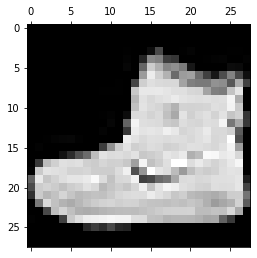

[9]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 23

In [10]:
print("The shape of the digits dataset:") 
print(X_train.shape)
plt.gray()
plt.matshow(X_train[0])
plt.show()
print(y_train[0:1])
print(X_train[0,:])

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
# Scale the dataset

X_scale = StandardScaler()
X_train = [X_scale.fit_transform(X_train[i]).flatten() for i in range(len(X_train))]

In [13]:
X_test = [X_scale.fit_transform(X_test[i]).flatten() for i in range(len(X_test))]



In [14]:
X_train[0] # Looking at the new features after scaling

array([-0.34062577, -0.48590849, -0.55368775, -0.57830472, -0.61724799,
       -0.65473466, -0.66524031, -0.69031625, -0.71089238, -0.73827078,
       -0.77682253, -0.7644687 , -0.90444624, -1.24217044, -1.49218887,
       -1.6432188 , -1.7458434 , -1.58582058, -1.56547495, -1.51925798,
       -1.44902444, -1.39545527, -1.35520903, -1.32176483, -1.33646764,
       -1.31334192, -1.22103858, -0.55220401, -0.34062577, -0.48590849,
       -0.55368775, -0.57830472, -0.61724799, -0.65473466, -0.66524031,
       -0.69031625, -0.71089238, -0.73827078, -0.77682253, -0.7644687 ,
       -0.90444624, -1.24217044, -1.49218887, -1.6432188 , -1.7458434 ,
       -1.58582058, -1.56547495, -1.51925798, -1.44902444, -1.39545527,
       -1.35520903, -1.32176483, -1.33646764, -1.31334192, -1.22103858,
       -0.55220401, -0.34062577, -0.48590849, -0.55368775, -0.57830472,
       -0.61724799, -0.65473466, -0.66524031, -0.69031625, -0.71089238,
       -0.73827078, -0.77682253, -0.7644687 , -0.90444624, -1.24

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
# Downsample the data

# Add y_train back as an additional column to X_train
y_train = y_train.reshape((-1,1))
X_train = np.append(X_train, y_train, axis=1)

# Add y_test back as an additional column to X_test
y_test = y_test.reshape((-1,1))
X_test = np.append(X_test, y_test, axis=1)

# Shuffle the data
np.random.shuffle(X_train)
np.random.shuffle(X_test)

# Slice out only the first 1078 from X_train and 719 from X_test
X_train = X_train[0:1078]
X_test = X_test[0:719]

# Remove the last columns of X_train and X_test and place them back into y_train and y_test
y_train = X_train[:,-1]
y_test = X_test[:,-1]
X_train = X_train[:,0:X_train.shape[1]-1]
X_test = X_test[:,0:X_test.shape[1]-1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1078, 784)
(1078,)
(719, 784)
(719,)


In [20]:
print(int(y_train[0]))

4


In [22]:
# Convert digits to vectors
y_v_train = convert_y_to_vect(y_train.astype(np.int))
y_v_test = convert_y_to_vect(y_test.astype(np.int))

(28, 28)
The shape of the digits dataset:
(1078, 784)


<Figure size 432x288 with 0 Axes>

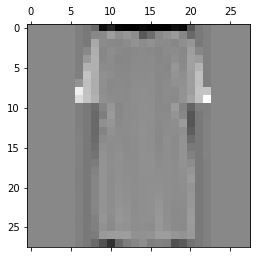

3.0


In [23]:
# Show that newly downsampled X_train still matches with y_train
# Here we display a pullover with label of 2 which is correct

X_train_test = np.zeros((28,28))
for i in range(28):
    X_train_test[i] = X_train[3][28*i:28*i+28]
print(X_train_test.shape)

print("The shape of the digits dataset:") 
print(X_train.shape)
plt.gray()
plt.matshow(X_train_test)
plt.show()
print(y_train[3])

(28, 28)
The shape of the digits dataset:
(1078, 784)


<Figure size 432x288 with 0 Axes>

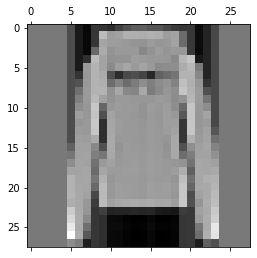

2.0


In [24]:
# Again we show that, as expected, an image of an ankle boot has a label of 9

X_train_test2 = np.zeros((28,28))
for i in range(28):
    X_train_test2[i] = X_train[435][28*i:28*i+28]
print(X_train_test2.shape)

print("The shape of the digits dataset:") 
print(X_train.shape)
plt.gray()
plt.matshow(X_train_test2)
plt.show()
print(y_train[435])

In [25]:
# Convert digits to vectors (one hot encoding)
y_v_train = convert_y_to_vect(y_train.astype(np.int))
y_v_test = convert_y_to_vect(y_test.astype(np.int))

In [29]:
# Sigmoid activation function

def f(z):
    return 1 / (1 + np.exp(-z))


def f_deriv(z):
    return f(z) * (1 - f(z))

In [40]:
def setup_and_init_weights(nn_structure):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

In [41]:
def init_tri_values(nn_structure):
    tri_W = {}
    tri_b = {}
    for l in range(1, len(nn_structure)):
        tri_W[l] = np.zeros((nn_structure[l], nn_structure[l-1]))
        tri_b[l] = np.zeros((nn_structure[l],))
    return tri_W, tri_b

In [42]:
def feed_forward(x, W, b):
    a = {1: x} # create a dictionary for holding the a values for all levels
    z = { } # create a dictionary for holding the z values for all the layers
    for l in range(1, len(W) + 1): # for each layer
        node_in = a[l]
        z[l+1] = W[l].dot(node_in) + b[l]  # z^(l+1) = W^(l)*a^(l) + b^(l)
        a[l+1] = f(z[l+1]) # a^(l+1) = f(z^(l+1))
    return a, z

In [43]:
def calculate_out_layer_delta(y, a_out, z_out):
    # delta^(nl) = -(y_i - a_i^(nl)) * f'(z_i^(nl))
    return -(y-a_out) * f_deriv(z_out) 


def calculate_hidden_delta(delta_plus_1, w_l, z_l):
    # delta^(l) = (transpose(W^(l)) * delta^(l+1)) * f'(z^(l))
    return np.dot(np.transpose(w_l), delta_plus_1) * f_deriv(z_l)

In [44]:
# Back propagation algorithm

def train_nn(nn_structure, X, y, iter_num=3000, alpha=0.25):
        W, b = setup_and_init_weights(nn_structure)
        cnt = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            print('Iteration {} of {}'.format(cnt, iter_num))
#             if cnt%1000 == 0:
#                 print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = init_tri_values(nn_structure)
            avg_cost = 0
            for i in range(N):
                delta = {}
                # perform the feed forward pass and return the stored a and z values, to be used in the
                # gradient descent step
                a, z = feed_forward(X[i, :], W, b)
                # loop from nl-1 to 1 backpropagating the errors
                for l in range(len(nn_structure), 0, -1):
                    if l == len(nn_structure):
                        delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                        avg_cost += np.linalg.norm((y[i,:]-a[l]))
                    else:
                        if l > 1:
                            delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                        tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                        # trib^(l) = trib^(l) + delta^(l+1)
                        tri_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(nn_structure) - 1, 0, -1):
                W[l] += -alpha * (1.0/N * tri_W[l])
                b[l] += -alpha * (1.0/N * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/N * avg_cost
            avg_cost_func.append(avg_cost)
            cnt += 1
        return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [45]:
nn_structure = [784, 128, 10]
    
# train the NN
W, b, avg_cost_func = train_nn(nn_structure, X_train, y_v_train, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1 of 3000
Iteration 2 of 3000
Iteration 3 of 3000
Iteration 4 of 3000
Iteration 5 of 3000
Iteration 6 of 3000
Iteration 7 of 3000
Iteration 8 of 3000
Iteration 9 of 3000
Iteration 10 of 3000
Iteration 11 of 3000
Iteration 12 of 3000
Iteration 13 of 3000
Iteration 14 of 3000
Iteration 15 of 3000
Iteration 16 of 3000
Iteration 17 of 3000
Iteration 18 of 3000
Iteration 19 of 3000
Iteration 20 of 3000
Iteration 21 of 3000
Iteration 22 of 3000
Iteration 23 of 3000
Iteration 24 of 3000
Iteration 25 of 3000
Iteration 26 of 3000
Iteration 27 of 3000
Iteration 28 of 3000
Iteration 29 of 3000
Iteration 30 of 3000
Iteration 31 of 3000
Iteration 32 of 3000
Iteration 33 of 3000
Iteration 34 of 3000
Iteration 35 of 3000
Iteration 36 of 3000
Iteration 37 of 3000
Iteration 38 of 3000
Iteration 39 of 3000
Iteration 40 of 3000
Iteration 41 of 3000
Iteration 42 of 3000
Iteration 43 of 3000
Iteration 44 of 3000
Iteration 45 of 300

Iteration 376 of 3000
Iteration 377 of 3000
Iteration 378 of 3000
Iteration 379 of 3000
Iteration 380 of 3000
Iteration 381 of 3000
Iteration 382 of 3000
Iteration 383 of 3000
Iteration 384 of 3000
Iteration 385 of 3000
Iteration 386 of 3000
Iteration 387 of 3000
Iteration 388 of 3000
Iteration 389 of 3000
Iteration 390 of 3000
Iteration 391 of 3000
Iteration 392 of 3000
Iteration 393 of 3000
Iteration 394 of 3000
Iteration 395 of 3000
Iteration 396 of 3000
Iteration 397 of 3000
Iteration 398 of 3000
Iteration 399 of 3000
Iteration 400 of 3000
Iteration 401 of 3000
Iteration 402 of 3000
Iteration 403 of 3000
Iteration 404 of 3000
Iteration 405 of 3000
Iteration 406 of 3000
Iteration 407 of 3000
Iteration 408 of 3000
Iteration 409 of 3000
Iteration 410 of 3000
Iteration 411 of 3000
Iteration 412 of 3000
Iteration 413 of 3000
Iteration 414 of 3000
Iteration 415 of 3000
Iteration 416 of 3000
Iteration 417 of 3000
Iteration 418 of 3000
Iteration 419 of 3000
Iteration 420 of 3000
Iteration 

Iteration 749 of 3000
Iteration 750 of 3000
Iteration 751 of 3000
Iteration 752 of 3000
Iteration 753 of 3000
Iteration 754 of 3000
Iteration 755 of 3000
Iteration 756 of 3000
Iteration 757 of 3000
Iteration 758 of 3000
Iteration 759 of 3000
Iteration 760 of 3000
Iteration 761 of 3000
Iteration 762 of 3000
Iteration 763 of 3000
Iteration 764 of 3000
Iteration 765 of 3000
Iteration 766 of 3000
Iteration 767 of 3000
Iteration 768 of 3000
Iteration 769 of 3000
Iteration 770 of 3000
Iteration 771 of 3000
Iteration 772 of 3000
Iteration 773 of 3000
Iteration 774 of 3000
Iteration 775 of 3000
Iteration 776 of 3000
Iteration 777 of 3000
Iteration 778 of 3000
Iteration 779 of 3000
Iteration 780 of 3000
Iteration 781 of 3000
Iteration 782 of 3000
Iteration 783 of 3000
Iteration 784 of 3000
Iteration 785 of 3000
Iteration 786 of 3000
Iteration 787 of 3000
Iteration 788 of 3000
Iteration 789 of 3000
Iteration 790 of 3000
Iteration 791 of 3000
Iteration 792 of 3000
Iteration 793 of 3000
Iteration 

Iteration 1117 of 3000
Iteration 1118 of 3000
Iteration 1119 of 3000
Iteration 1120 of 3000
Iteration 1121 of 3000
Iteration 1122 of 3000
Iteration 1123 of 3000
Iteration 1124 of 3000
Iteration 1125 of 3000
Iteration 1126 of 3000
Iteration 1127 of 3000
Iteration 1128 of 3000
Iteration 1129 of 3000
Iteration 1130 of 3000
Iteration 1131 of 3000
Iteration 1132 of 3000
Iteration 1133 of 3000
Iteration 1134 of 3000
Iteration 1135 of 3000
Iteration 1136 of 3000
Iteration 1137 of 3000
Iteration 1138 of 3000
Iteration 1139 of 3000
Iteration 1140 of 3000
Iteration 1141 of 3000
Iteration 1142 of 3000
Iteration 1143 of 3000
Iteration 1144 of 3000
Iteration 1145 of 3000
Iteration 1146 of 3000
Iteration 1147 of 3000
Iteration 1148 of 3000
Iteration 1149 of 3000
Iteration 1150 of 3000
Iteration 1151 of 3000
Iteration 1152 of 3000
Iteration 1153 of 3000
Iteration 1154 of 3000
Iteration 1155 of 3000
Iteration 1156 of 3000
Iteration 1157 of 3000
Iteration 1158 of 3000
Iteration 1159 of 3000
Iteration 1

Iteration 1474 of 3000
Iteration 1475 of 3000
Iteration 1476 of 3000
Iteration 1477 of 3000
Iteration 1478 of 3000
Iteration 1479 of 3000
Iteration 1480 of 3000
Iteration 1481 of 3000
Iteration 1482 of 3000
Iteration 1483 of 3000
Iteration 1484 of 3000
Iteration 1485 of 3000
Iteration 1486 of 3000
Iteration 1487 of 3000
Iteration 1488 of 3000
Iteration 1489 of 3000
Iteration 1490 of 3000
Iteration 1491 of 3000
Iteration 1492 of 3000
Iteration 1493 of 3000
Iteration 1494 of 3000
Iteration 1495 of 3000
Iteration 1496 of 3000
Iteration 1497 of 3000
Iteration 1498 of 3000
Iteration 1499 of 3000
Iteration 1500 of 3000
Iteration 1501 of 3000
Iteration 1502 of 3000
Iteration 1503 of 3000
Iteration 1504 of 3000
Iteration 1505 of 3000
Iteration 1506 of 3000
Iteration 1507 of 3000
Iteration 1508 of 3000
Iteration 1509 of 3000
Iteration 1510 of 3000
Iteration 1511 of 3000
Iteration 1512 of 3000
Iteration 1513 of 3000
Iteration 1514 of 3000
Iteration 1515 of 3000
Iteration 1516 of 3000
Iteration 1

Iteration 1831 of 3000
Iteration 1832 of 3000
Iteration 1833 of 3000
Iteration 1834 of 3000
Iteration 1835 of 3000
Iteration 1836 of 3000
Iteration 1837 of 3000
Iteration 1838 of 3000
Iteration 1839 of 3000
Iteration 1840 of 3000
Iteration 1841 of 3000
Iteration 1842 of 3000
Iteration 1843 of 3000
Iteration 1844 of 3000
Iteration 1845 of 3000
Iteration 1846 of 3000
Iteration 1847 of 3000
Iteration 1848 of 3000
Iteration 1849 of 3000
Iteration 1850 of 3000
Iteration 1851 of 3000
Iteration 1852 of 3000
Iteration 1853 of 3000
Iteration 1854 of 3000
Iteration 1855 of 3000
Iteration 1856 of 3000
Iteration 1857 of 3000
Iteration 1858 of 3000
Iteration 1859 of 3000
Iteration 1860 of 3000
Iteration 1861 of 3000
Iteration 1862 of 3000
Iteration 1863 of 3000
Iteration 1864 of 3000
Iteration 1865 of 3000
Iteration 1866 of 3000
Iteration 1867 of 3000
Iteration 1868 of 3000
Iteration 1869 of 3000
Iteration 1870 of 3000
Iteration 1871 of 3000
Iteration 1872 of 3000
Iteration 1873 of 3000
Iteration 1

Iteration 2188 of 3000
Iteration 2189 of 3000
Iteration 2190 of 3000
Iteration 2191 of 3000
Iteration 2192 of 3000
Iteration 2193 of 3000
Iteration 2194 of 3000
Iteration 2195 of 3000
Iteration 2196 of 3000
Iteration 2197 of 3000
Iteration 2198 of 3000
Iteration 2199 of 3000
Iteration 2200 of 3000
Iteration 2201 of 3000
Iteration 2202 of 3000
Iteration 2203 of 3000
Iteration 2204 of 3000
Iteration 2205 of 3000
Iteration 2206 of 3000
Iteration 2207 of 3000
Iteration 2208 of 3000
Iteration 2209 of 3000
Iteration 2210 of 3000
Iteration 2211 of 3000
Iteration 2212 of 3000
Iteration 2213 of 3000
Iteration 2214 of 3000
Iteration 2215 of 3000
Iteration 2216 of 3000
Iteration 2217 of 3000
Iteration 2218 of 3000
Iteration 2219 of 3000
Iteration 2220 of 3000
Iteration 2221 of 3000
Iteration 2222 of 3000
Iteration 2223 of 3000
Iteration 2224 of 3000
Iteration 2225 of 3000
Iteration 2226 of 3000
Iteration 2227 of 3000
Iteration 2228 of 3000
Iteration 2229 of 3000
Iteration 2230 of 3000
Iteration 2

Iteration 2545 of 3000
Iteration 2546 of 3000
Iteration 2547 of 3000
Iteration 2548 of 3000
Iteration 2549 of 3000
Iteration 2550 of 3000
Iteration 2551 of 3000
Iteration 2552 of 3000
Iteration 2553 of 3000
Iteration 2554 of 3000
Iteration 2555 of 3000
Iteration 2556 of 3000
Iteration 2557 of 3000
Iteration 2558 of 3000
Iteration 2559 of 3000
Iteration 2560 of 3000
Iteration 2561 of 3000
Iteration 2562 of 3000
Iteration 2563 of 3000
Iteration 2564 of 3000
Iteration 2565 of 3000
Iteration 2566 of 3000
Iteration 2567 of 3000
Iteration 2568 of 3000
Iteration 2569 of 3000
Iteration 2570 of 3000
Iteration 2571 of 3000
Iteration 2572 of 3000
Iteration 2573 of 3000
Iteration 2574 of 3000
Iteration 2575 of 3000
Iteration 2576 of 3000
Iteration 2577 of 3000
Iteration 2578 of 3000
Iteration 2579 of 3000
Iteration 2580 of 3000
Iteration 2581 of 3000
Iteration 2582 of 3000
Iteration 2583 of 3000
Iteration 2584 of 3000
Iteration 2585 of 3000
Iteration 2586 of 3000
Iteration 2587 of 3000
Iteration 2

Iteration 2902 of 3000
Iteration 2903 of 3000
Iteration 2904 of 3000
Iteration 2905 of 3000
Iteration 2906 of 3000
Iteration 2907 of 3000
Iteration 2908 of 3000
Iteration 2909 of 3000
Iteration 2910 of 3000
Iteration 2911 of 3000
Iteration 2912 of 3000
Iteration 2913 of 3000
Iteration 2914 of 3000
Iteration 2915 of 3000
Iteration 2916 of 3000
Iteration 2917 of 3000
Iteration 2918 of 3000
Iteration 2919 of 3000
Iteration 2920 of 3000
Iteration 2921 of 3000
Iteration 2922 of 3000
Iteration 2923 of 3000
Iteration 2924 of 3000
Iteration 2925 of 3000
Iteration 2926 of 3000
Iteration 2927 of 3000
Iteration 2928 of 3000
Iteration 2929 of 3000
Iteration 2930 of 3000
Iteration 2931 of 3000
Iteration 2932 of 3000
Iteration 2933 of 3000
Iteration 2934 of 3000
Iteration 2935 of 3000
Iteration 2936 of 3000
Iteration 2937 of 3000
Iteration 2938 of 3000
Iteration 2939 of 3000
Iteration 2940 of 3000
Iteration 2941 of 3000
Iteration 2942 of 3000
Iteration 2943 of 3000
Iteration 2944 of 3000
Iteration 2

In [46]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 9.874826147426981%


### Extended implementation using Numpy

In [35]:
import random

def setup_and_init_weights_with_dropout(nn_structure, input_dropout_rate, hidden_dropout_rate):
    W = {} #creating a dictionary i.e. a set of key: value pairs
    b = {}
    for l in range(1, len(nn_structure)):
        W[l] = r.random_sample((nn_structure[l], nn_structure[l-1])) #Return “continuous uniform” random floats in the half-open interval [0.0, 1.0). 
        b[l] = r.random_sample((nn_structure[l],))
    return W, b

    active_input_nodes = int(nn_structure[0]*(1/input_dropout_rate))
    active_input_indices = sorted(random.sample(range(0, nn_structure[0]), active_input_nodes))
    active_hidden_nodes = int(nn_structure[1]*(1/input_dropout_rate))
    active_hidden_indices = sorted(random.sample(range(0, nn_structure[1]), active_input_nodes))
    
    # Randomly remove weights from input layer
    for i in range(len(active_input_indices)):
        W[1].remove(active_input_indices[i])
    
    # Randomly remove weights from hidden layer
    for i in range(len(active_input_indices)):
        W[2].remove(active_input_indices[i])
    

In [36]:
# Back propagation algorithm

def train_nn_with_dropout(nn_structure, X, y, input_dropout_rate, hidden_dropout_rate, iter_num=3000, alpha=0.25):
        W, b = setup_and_init_weights_with_dropout(nn_structure, input_dropout_rate, hidden_dropout_rate)
        cnt = 0
        N = len(y)
        avg_cost_func = []
        print('Starting gradient descent for {} iterations'.format(iter_num))
        while cnt < iter_num:
            print('Iteration {} of {}'.format(cnt, iter_num))
#             if cnt%1000 == 0:
#                 print('Iteration {} of {}'.format(cnt, iter_num))
            tri_W, tri_b = init_tri_values(nn_structure)
            avg_cost = 0
            for i in range(N):
                delta = {}
                # perform the feed forward pass and return the stored a and z values, to be used in the
                # gradient descent step
                a, z = feed_forward(X[i, :], W, b)
                # loop from nl-1 to 1 backpropagating the errors
                for l in range(len(nn_structure), 0, -1):
                    if l == len(nn_structure):
                        delta[l] = calculate_out_layer_delta(y[i,:], a[l], z[l])
                        avg_cost += np.linalg.norm((y[i,:]-a[l]))
                    else:
                        if l > 1:
                            delta[l] = calculate_hidden_delta(delta[l+1], W[l], z[l])
                        # triW^(l) = triW^(l) + delta^(l+1) * transpose(a^(l))
                        tri_W[l] += np.dot(delta[l+1][:,np.newaxis], np.transpose(a[l][:,np.newaxis]))# np.newaxis increase the number of dimensions
                        # trib^(l) = trib^(l) + delta^(l+1)
                        tri_b[l] += delta[l+1]
            # perform the gradient descent step for the weights in each layer
            for l in range(len(nn_structure) - 1, 0, -1):
                # Set maximum norm weight constraint = 3
                if np.linalg.norm(W[l]) > 7:
                    desired = np.clip(np.linalg.norm(W[l]), 0, 7)
                    W[l] *= (desired / np.linalg.norm(W[l]))
                W[l] += -alpha * (1.0/N * tri_W[l])
                b[l] += -alpha * (1.0/N * tri_b[l])
            # complete the average cost calculation
            avg_cost = 1.0/N * avg_cost
            avg_cost_func.append(avg_cost)
            cnt += 1
        return W, b, avg_cost_func


def predict_y(W, b, X, n_layers):
    N = X.shape[0]
    y = np.zeros((N,))
    for i in range(N):
        a, z = feed_forward(X[i, :], W, b)
        y[i] = np.argmax(a[n_layers])
    return y

In [37]:
nn_structure = [784, 128, 10]

input_dropout_rate = 0.2
hidden_dropout_rate = 0.2 
    
# train the NN with dropout
W, b, avg_cost_func = train_nn_with_dropout(nn_structure, X_train, y_v_train, input_dropout_rate, hidden_dropout_rate, 3000)

Starting gradient descent for 3000 iterations
Iteration 0 of 3000
Iteration 1 of 3000
Iteration 2 of 3000
Iteration 3 of 3000
Iteration 4 of 3000
Iteration 5 of 3000
Iteration 6 of 3000
Iteration 7 of 3000
Iteration 8 of 3000
Iteration 9 of 3000
Iteration 10 of 3000
Iteration 11 of 3000
Iteration 12 of 3000
Iteration 13 of 3000
Iteration 14 of 3000
Iteration 15 of 3000
Iteration 16 of 3000
Iteration 17 of 3000
Iteration 18 of 3000
Iteration 19 of 3000
Iteration 20 of 3000
Iteration 21 of 3000
Iteration 22 of 3000
Iteration 23 of 3000
Iteration 24 of 3000
Iteration 25 of 3000
Iteration 26 of 3000
Iteration 27 of 3000
Iteration 28 of 3000
Iteration 29 of 3000
Iteration 30 of 3000
Iteration 31 of 3000
Iteration 32 of 3000
Iteration 33 of 3000
Iteration 34 of 3000
Iteration 35 of 3000
Iteration 36 of 3000
Iteration 37 of 3000
Iteration 38 of 3000
Iteration 39 of 3000
Iteration 40 of 3000
Iteration 41 of 3000
Iteration 42 of 3000
Iteration 43 of 3000
Iteration 44 of 3000
Iteration 45 of 300

Iteration 376 of 3000
Iteration 377 of 3000
Iteration 378 of 3000
Iteration 379 of 3000
Iteration 380 of 3000
Iteration 381 of 3000
Iteration 382 of 3000
Iteration 383 of 3000
Iteration 384 of 3000
Iteration 385 of 3000
Iteration 386 of 3000
Iteration 387 of 3000
Iteration 388 of 3000
Iteration 389 of 3000
Iteration 390 of 3000
Iteration 391 of 3000
Iteration 392 of 3000
Iteration 393 of 3000
Iteration 394 of 3000
Iteration 395 of 3000
Iteration 396 of 3000
Iteration 397 of 3000
Iteration 398 of 3000
Iteration 399 of 3000
Iteration 400 of 3000
Iteration 401 of 3000
Iteration 402 of 3000
Iteration 403 of 3000
Iteration 404 of 3000
Iteration 405 of 3000
Iteration 406 of 3000
Iteration 407 of 3000
Iteration 408 of 3000
Iteration 409 of 3000
Iteration 410 of 3000
Iteration 411 of 3000
Iteration 412 of 3000
Iteration 413 of 3000
Iteration 414 of 3000
Iteration 415 of 3000
Iteration 416 of 3000
Iteration 417 of 3000
Iteration 418 of 3000
Iteration 419 of 3000
Iteration 420 of 3000
Iteration 

Iteration 749 of 3000
Iteration 750 of 3000
Iteration 751 of 3000
Iteration 752 of 3000
Iteration 753 of 3000
Iteration 754 of 3000
Iteration 755 of 3000
Iteration 756 of 3000
Iteration 757 of 3000
Iteration 758 of 3000
Iteration 759 of 3000
Iteration 760 of 3000
Iteration 761 of 3000
Iteration 762 of 3000
Iteration 763 of 3000
Iteration 764 of 3000
Iteration 765 of 3000
Iteration 766 of 3000
Iteration 767 of 3000
Iteration 768 of 3000
Iteration 769 of 3000
Iteration 770 of 3000
Iteration 771 of 3000
Iteration 772 of 3000
Iteration 773 of 3000
Iteration 774 of 3000
Iteration 775 of 3000
Iteration 776 of 3000
Iteration 777 of 3000
Iteration 778 of 3000
Iteration 779 of 3000
Iteration 780 of 3000
Iteration 781 of 3000
Iteration 782 of 3000
Iteration 783 of 3000
Iteration 784 of 3000
Iteration 785 of 3000
Iteration 786 of 3000
Iteration 787 of 3000
Iteration 788 of 3000
Iteration 789 of 3000
Iteration 790 of 3000
Iteration 791 of 3000
Iteration 792 of 3000
Iteration 793 of 3000
Iteration 

Iteration 1117 of 3000
Iteration 1118 of 3000
Iteration 1119 of 3000
Iteration 1120 of 3000
Iteration 1121 of 3000
Iteration 1122 of 3000
Iteration 1123 of 3000
Iteration 1124 of 3000
Iteration 1125 of 3000
Iteration 1126 of 3000
Iteration 1127 of 3000
Iteration 1128 of 3000
Iteration 1129 of 3000
Iteration 1130 of 3000
Iteration 1131 of 3000
Iteration 1132 of 3000
Iteration 1133 of 3000
Iteration 1134 of 3000
Iteration 1135 of 3000
Iteration 1136 of 3000
Iteration 1137 of 3000
Iteration 1138 of 3000
Iteration 1139 of 3000
Iteration 1140 of 3000
Iteration 1141 of 3000
Iteration 1142 of 3000
Iteration 1143 of 3000
Iteration 1144 of 3000
Iteration 1145 of 3000
Iteration 1146 of 3000
Iteration 1147 of 3000
Iteration 1148 of 3000
Iteration 1149 of 3000
Iteration 1150 of 3000
Iteration 1151 of 3000
Iteration 1152 of 3000
Iteration 1153 of 3000
Iteration 1154 of 3000
Iteration 1155 of 3000
Iteration 1156 of 3000
Iteration 1157 of 3000
Iteration 1158 of 3000
Iteration 1159 of 3000
Iteration 1

Iteration 1474 of 3000
Iteration 1475 of 3000
Iteration 1476 of 3000
Iteration 1477 of 3000
Iteration 1478 of 3000
Iteration 1479 of 3000
Iteration 1480 of 3000
Iteration 1481 of 3000
Iteration 1482 of 3000
Iteration 1483 of 3000
Iteration 1484 of 3000
Iteration 1485 of 3000
Iteration 1486 of 3000
Iteration 1487 of 3000
Iteration 1488 of 3000
Iteration 1489 of 3000
Iteration 1490 of 3000
Iteration 1491 of 3000
Iteration 1492 of 3000
Iteration 1493 of 3000
Iteration 1494 of 3000
Iteration 1495 of 3000
Iteration 1496 of 3000
Iteration 1497 of 3000
Iteration 1498 of 3000
Iteration 1499 of 3000
Iteration 1500 of 3000
Iteration 1501 of 3000
Iteration 1502 of 3000
Iteration 1503 of 3000
Iteration 1504 of 3000
Iteration 1505 of 3000
Iteration 1506 of 3000
Iteration 1507 of 3000
Iteration 1508 of 3000
Iteration 1509 of 3000
Iteration 1510 of 3000
Iteration 1511 of 3000
Iteration 1512 of 3000
Iteration 1513 of 3000
Iteration 1514 of 3000
Iteration 1515 of 3000
Iteration 1516 of 3000
Iteration 1

Iteration 1831 of 3000
Iteration 1832 of 3000
Iteration 1833 of 3000
Iteration 1834 of 3000
Iteration 1835 of 3000
Iteration 1836 of 3000
Iteration 1837 of 3000
Iteration 1838 of 3000
Iteration 1839 of 3000
Iteration 1840 of 3000
Iteration 1841 of 3000
Iteration 1842 of 3000
Iteration 1843 of 3000
Iteration 1844 of 3000
Iteration 1845 of 3000
Iteration 1846 of 3000
Iteration 1847 of 3000
Iteration 1848 of 3000
Iteration 1849 of 3000
Iteration 1850 of 3000
Iteration 1851 of 3000
Iteration 1852 of 3000
Iteration 1853 of 3000
Iteration 1854 of 3000
Iteration 1855 of 3000
Iteration 1856 of 3000
Iteration 1857 of 3000
Iteration 1858 of 3000
Iteration 1859 of 3000
Iteration 1860 of 3000
Iteration 1861 of 3000
Iteration 1862 of 3000
Iteration 1863 of 3000
Iteration 1864 of 3000
Iteration 1865 of 3000
Iteration 1866 of 3000
Iteration 1867 of 3000
Iteration 1868 of 3000
Iteration 1869 of 3000
Iteration 1870 of 3000
Iteration 1871 of 3000
Iteration 1872 of 3000
Iteration 1873 of 3000
Iteration 1

Iteration 2188 of 3000
Iteration 2189 of 3000
Iteration 2190 of 3000
Iteration 2191 of 3000
Iteration 2192 of 3000
Iteration 2193 of 3000
Iteration 2194 of 3000
Iteration 2195 of 3000
Iteration 2196 of 3000
Iteration 2197 of 3000
Iteration 2198 of 3000
Iteration 2199 of 3000
Iteration 2200 of 3000
Iteration 2201 of 3000
Iteration 2202 of 3000
Iteration 2203 of 3000
Iteration 2204 of 3000
Iteration 2205 of 3000
Iteration 2206 of 3000
Iteration 2207 of 3000
Iteration 2208 of 3000
Iteration 2209 of 3000
Iteration 2210 of 3000
Iteration 2211 of 3000
Iteration 2212 of 3000
Iteration 2213 of 3000
Iteration 2214 of 3000
Iteration 2215 of 3000
Iteration 2216 of 3000
Iteration 2217 of 3000
Iteration 2218 of 3000
Iteration 2219 of 3000
Iteration 2220 of 3000
Iteration 2221 of 3000
Iteration 2222 of 3000
Iteration 2223 of 3000
Iteration 2224 of 3000
Iteration 2225 of 3000
Iteration 2226 of 3000
Iteration 2227 of 3000
Iteration 2228 of 3000
Iteration 2229 of 3000
Iteration 2230 of 3000
Iteration 2

Iteration 2545 of 3000
Iteration 2546 of 3000
Iteration 2547 of 3000
Iteration 2548 of 3000
Iteration 2549 of 3000
Iteration 2550 of 3000
Iteration 2551 of 3000
Iteration 2552 of 3000
Iteration 2553 of 3000
Iteration 2554 of 3000
Iteration 2555 of 3000
Iteration 2556 of 3000
Iteration 2557 of 3000
Iteration 2558 of 3000
Iteration 2559 of 3000
Iteration 2560 of 3000
Iteration 2561 of 3000
Iteration 2562 of 3000
Iteration 2563 of 3000
Iteration 2564 of 3000
Iteration 2565 of 3000
Iteration 2566 of 3000
Iteration 2567 of 3000
Iteration 2568 of 3000
Iteration 2569 of 3000
Iteration 2570 of 3000
Iteration 2571 of 3000
Iteration 2572 of 3000
Iteration 2573 of 3000
Iteration 2574 of 3000
Iteration 2575 of 3000
Iteration 2576 of 3000
Iteration 2577 of 3000
Iteration 2578 of 3000
Iteration 2579 of 3000
Iteration 2580 of 3000
Iteration 2581 of 3000
Iteration 2582 of 3000
Iteration 2583 of 3000
Iteration 2584 of 3000
Iteration 2585 of 3000
Iteration 2586 of 3000
Iteration 2587 of 3000
Iteration 2

Iteration 2902 of 3000
Iteration 2903 of 3000
Iteration 2904 of 3000
Iteration 2905 of 3000
Iteration 2906 of 3000
Iteration 2907 of 3000
Iteration 2908 of 3000
Iteration 2909 of 3000
Iteration 2910 of 3000
Iteration 2911 of 3000
Iteration 2912 of 3000
Iteration 2913 of 3000
Iteration 2914 of 3000
Iteration 2915 of 3000
Iteration 2916 of 3000
Iteration 2917 of 3000
Iteration 2918 of 3000
Iteration 2919 of 3000
Iteration 2920 of 3000
Iteration 2921 of 3000
Iteration 2922 of 3000
Iteration 2923 of 3000
Iteration 2924 of 3000
Iteration 2925 of 3000
Iteration 2926 of 3000
Iteration 2927 of 3000
Iteration 2928 of 3000
Iteration 2929 of 3000
Iteration 2930 of 3000
Iteration 2931 of 3000
Iteration 2932 of 3000
Iteration 2933 of 3000
Iteration 2934 of 3000
Iteration 2935 of 3000
Iteration 2936 of 3000
Iteration 2937 of 3000
Iteration 2938 of 3000
Iteration 2939 of 3000
Iteration 2940 of 3000
Iteration 2941 of 3000
Iteration 2942 of 3000
Iteration 2943 of 3000
Iteration 2944 of 3000
Iteration 2

In [38]:
# get the prediction accuracy and print
y_pred = predict_y(W, b, X_test, 3)
print('Prediction accuracy is {}%'.format(accuracy_score(y_test, y_pred) * 100))

Prediction accuracy is 11.821974965229485%
